<a href="https://colab.research.google.com/github/luisdzanetta/portfolio_projetos/blob/main/Projeto_1_Teste_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Chi-square approach AB test**

##**Experiment setup**

#### **Data**
[Kaggle - A/B testing Dataset](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?resource=download)

#### **Scenario**
We will conduct an A/B test for a hypothetical company trying to increase sales of a **product XY** in the online store (e-commerce).

#### **Objective**
The objective of performing an A/B test is to assess whether a specific change on the sales page will lead to better performance in a specific metric.

#### **Metrics**
The current **conversion rate is 13%** (Page A). That is, for every 100 people who visit the page, 13 buy the **product XY**. For this example, we want to confirm that the changes made to the sales page (Page B) will result in an increase of at least **2%** in conversion.

#### **Hypotheses**
Considering that Page A is currently being used, i.e., with a conversion rate of 13%, and Page B is the modified page to be tested:

$H_0$: There is no association between the page and the conversion rate.

$H_1$: There is an association between the page and the conversion rate.

---

#### **Sample**
The sample needed to observe the requested effect was calculated using the [pingouin](https://pingouin-stats.org/index.html) library and the software G * Power v.3.1.9.7 (G * Power, 2021; Bartlett, 2022), considering the following input parameters:

**Test family:** Χ² tests

**Statistic test:** Goodness-of-fit tests: Contingency tables

**Effect size (d):** 0.02

**Alpha (α):** 0.05

**Power (1-β):** 0.95

**Degrees of Freedom:** ${DF} = {(r-1)} * {(c-1)}$

DF = Degree of Freedom;
r = Number of rows;
c = Number of columns


##**Bibliotecas**

In [ ]:
#Bibliotecas
import pandas as pd
#! pip install pingouin
import pingouin as pg
from pingouin import power_chi2

##**Cálculo amostral**

In [ ]:
#Cálculo amostral utilizando a função power_ttest da biblioteca pingouin

sample_size = power_chi2(dof=1,
                          w=0.02,
                          power = 0.95,
                          alpha = 0.05)

print('Amostra por grupo = %.f' %sample_size)

Amostra por grupo = 32487


Cálculo amostral via G * Power

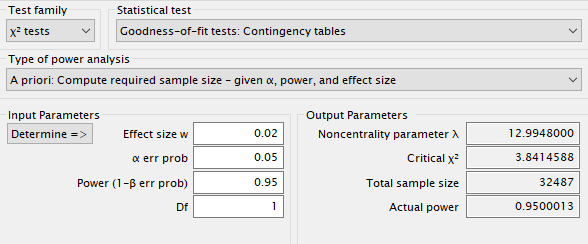

##**Base de Dados**

In [ ]:
#Carregar BD
#from google.colab import files
#uploaded = files.upload()

In [ ]:
df_raw = pd.read_csv('Projeto#1_Teste_AB.csv')

In [ ]:
df_raw.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

##**Análise Descritiva**

In [ ]:
#Número de linhas e de colunas do df
print('Número de linhas: %.f' %df_raw.shape[0])
print('Número de colunas: %.f' %df_raw.shape[1])

Número de linhas: 294478
Número de colunas: 5


In [ ]:
#Check: NA
df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
#Check1: control = old_page & treatment = new_page
df_raw[['user_id',
        'group',
        'landing_page']].groupby(['group',
                                  'landing_page']).count().reset_index()

group landing_page  user_id
0    control     new_page     1928
1    control     old_page   145274
2  treatment     new_page   145311
3  treatment     old_page     1965

In [ ]:
#Identificar valores que estão duplicados, ou seja, em ambos os grupos
df_user_delete = df_raw[['user_id',
                         'group',
                         'landing_page']].groupby(['user_id']).count().reset_index().query('group > 1')
print('O número de usuários duplicados é: %.f' %df_user_delete.shape[0])

O número de usuários duplicados é: 3894


In [ ]:
#Deletar usuários duplicados
df1 = df_raw.drop_duplicates('user_id', keep=False)
print('O número de usuários após deletar os user_id duplicados é: %.f' %df1.shape[0])

O número de usuários após deletar os user_id duplicados é: 286690


In [ ]:
#Check2: control = old_page & treatment = new_page
df1[['user_id',
        'group',
        'landing_page']].groupby(['group',
                                  'landing_page']).count().reset_index()

group landing_page  user_id
0    control     old_page   143293
1  treatment     new_page   143397

##**Amostragem**

In [ ]:
#Grupo Controle (A)
df_gc = df1[df1['group'] == 'control'].sample(n=int(sample_size/2), random_state = 42)
print('N Grupo Controle = %.f' %df_gc.shape[0])

#Grupo Tratamento (B)
df_gt = df1[df1['group'] == 'treatment'].sample(n=int(sample_size/2), random_state = 42)
print('N Grupo Tratamento = %.f' %df_gt.shape[0])

#Concatenar os grupos em um df
df_ab = pd.concat([df_gc, df_gt]).reset_index(drop = True)
print('N df_ab = %.f' %df_ab.shape[0])

N Grupo Controle = 16243
N Grupo Tratamento = 16243
N df_ab = 32486


##**Cálculo da conversão das páginas**

${Conversão} = \frac{Clientes}{Visitantes}$

In [ ]:
#Conversão página A - Controle
clientes_gc = df_gc.loc[df_gc['converted'] == 1, 'converted'].sum()
visitantes_gc = df_gc.shape[0]
conversao_gc = clientes_gc / visitantes_gc

print('A taxa de conversão da página A foi de {:.2f}%' .format(conversao_gc*100))

#Conversão página B - Tratamento
clientes_gt = df_gt.loc[df_gt['converted'] == 1, 'converted'].sum()
visitantes_gt = df_gt.shape[0]
conversao_gt = clientes_gt / visitantes_gt

print('A taxa de conversao da página B foi de {:.2f}%' .format(conversao_gt*100))

A taxa de conversão da página A foi de 11.94%
A taxa de conversao da página B foi de 12.05%


##**Teste Estatístico - Qui-Quadrado**

**Qui-Quadrado (χ2) definição:** A statistic having, at least approximately, a chi-squared distribution. An example is the test statistic used to assess the independence :of the two variables forming a contingency table where Oi represents an observed frequency and Ei the expected frequency under independence. Under the hypothesis of independence χ2 has, approximately, a chi-squared distribution with (r−1)(c−1) degrees of freedom [(Everitt & Skrondal, 2010)](http://www.stewartschultz.com/statistics/books/Cambridge%20Dictionary%20Statistics%204th.pdf).

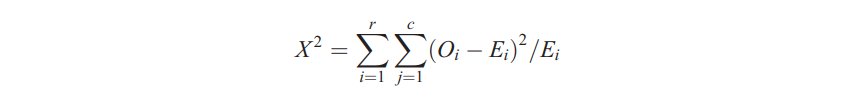


In [ ]:
#Qui-Quadrado (Chi-sqaured [χ2])

expected, observed, stats = pg.chi2_independence(df_ab, x='group',
                                                 y='converted')


In [ ]:
#Valores esperados

expected

converted        0       1
group                     
control    14294.5  1948.5
treatment  14294.5  1948.5

In [ ]:
#Valores observados

observed

converted        0       1
group                     
control    14303.5  1939.5
treatment  14285.5  1957.5

The test summary columns [(Vallat, 2022)](https://pingouin-stats.org/generated/pingouin.chi2_independence.html#pingouin.chi2_independence):

* test: The statistic name

* lambda: The λ value used for the power divergence statistic

* chi2: The test statistic

* pval: The p-value of the test

* cramer: The Cramer’s V effect size

* power: The statistical power of the test


In [ ]:
#Estatísitcas do Teste
stats.round(3)

test  lambda   chi2  dof   pval  cramer  power
0             pearson   1.000  0.094  1.0  0.759   0.002  0.061
1        cressie-read   0.667  0.094  1.0  0.759   0.002  0.061
2      log-likelihood   0.000  0.094  1.0  0.759   0.002  0.061
3       freeman-tukey  -0.500  0.094  1.0  0.759   0.002  0.061
4  mod-log-likelihood  -1.000  0.094  1.0  0.759   0.002  0.061
5              neyman  -2.000  0.094  1.0  0.759   0.002  0.061

##**Resultados**

Foi realizado um teste de qui-quadrado de independência (2x2) com objetivo de investigar se havia associação entre a conversão (sim e não) e o a página de venda (página A e página B). Não foi encontrada associação significativa entre a página e a conversão (χ2(1) = 0,094, p = 0,8759).

##**Referências**

Bartlett, J. (2022). Introduction to Power Analysis: A Guide to G*Power, jamovi, and Superpower. https://doi.org/10.17605/OSF.IO/PCFVJ

Everitt, B. S., & Skrondal, A. (2010). The Cambridge Dictionary of Statistics. https://doi.org/10.1017/cbo9780511779633

G * Power 3.1 manual. (2017). https://rdo.psu.ac.th/ResearchStandards/animal/assets/document/GPower3-2.pdf

Vallat, R. pingouin.chi2_independence — pingouin 0.5.2 documentation. (n.d.).Pingouin-Stats.org. Retrieved October 2, 2022, from https://pingouin-stats.org/generated/pingouin.chi2_independence.html#pingouin.chi2_independence